# Wragmuk World Gen

One of the things I want for Wragmuk is an "earth-like" world to explore.
Additionally, one of the key concepts behind Wragmuk is the procedural generation of it's world, interactions, etc. which leads to some very important things needed:

* We need to define what "earth-like" means
* Tile B should be independent of it's surroundings, in that I can procedurally determine everything in Tile B
  * This doesn't mean Tile B can't use information from Tile A. The big issue here is limiting the # of Tile A's needed for Tile B
  * As an example, I can do a blur filter in that a center tile C's final value depends on the "initial" values of the tiles around it. The initial values of the tiles around it can be computed with no additional information (just a random number for example), and thus the center tile is bounded in the information needed to generate it
* Every tile should be deterministic. ie: the same inputs should yield the same outputs
  * For "random", this means using a pre-seeded RNG, that utilizes the same seed on the same tile every time. 

Let's cover some basic concepts needed

## Earth-like worlds

Let's start with the simplest criteria, water / land ratio. Per the [USGS, Earth is about 71% water](https://www.usgs.gov/media/images/distribution-water-and-above-earth). 

Generating a world that comes close to this criteria is relatively simple, for each "tile" pick a random number in the range `[0.0, 1.0]`. If it's <= 0.71, then it is water, otherwise it's land.
We can demonstrate this with a fairly simple test bed:

In [32]:
# Prep work
from scipy.special import binom
import numpy as np
import matplotlib.pyplot as plt
import random
from functools import reduce
from operator import xor
import sys
import math

In [39]:
# Helper functions for deterministic RNG
max_int = sys.maxsize
min_int = ~sys.maxsize
def deterministic_rng_float(seed):
    random.seed(seed)
    return random.random()

def deterministic_rng_int(seed):
    random.seed(seed)
    return random.randint(min_int, max_int)


def deterministic_rng_multi_float(seeds):
    seed_eval = [deterministic_rng_int(seed) for seed in seeds]
    new_seed = reduce(xor, seed_eval)
    return deterministic_rng_float(new_seed)

Water/Area percentage: 72%


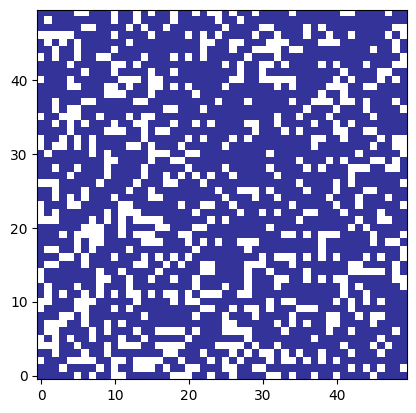

In [38]:
# Simple water/land gen
image_size = 50
pixels = np.zeros((image_size, image_size))
cache = {}

seed = 1231
water_value = 0
land_value = 10
water_percentage = 0.71

water_count = 0
land_count = 0

for row in range(image_size):
    for col in range(image_size):
        # Deterministic random:
        roll = deterministic_rng_multi_float([deterministic_rng_int(row), col, seed])
        if roll < water_percentage:
            pixels[row,col] = water_value
            water_count += 1
        else:
            pixels[row, col] = land_value
            land_count += 1
plt.imshow(pixels, origin='lower', cmap='terrain')
# purple is 0

water_percentage = (1.0 * water_count) / (water_count + land_count)
print(f"Water/Area percentage: {water_percentage:.0%}")

As seen with the test bed, while this does fulfil the simple criteria, it is definitely not "earth-like". The water and land are fairly evenly distributed, whereas in Earth, we have large masses of lands called continents surrounded by large swaths of water called oceans. 

To achieve this, we could take advantage of functions that have smaller gradients, ie: squares close together will have similar values. An easy one used commonly in procedural generation are the trigonometric functions such as sin:

Water/Area percentage: 80%


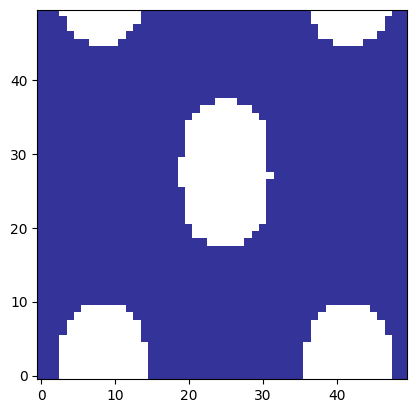

In [30]:
# Simple landmass gen
image_size = 50
pixels = np.zeros((image_size, image_size))
cache = {}

water_value = 0
land_value = 10
water_percentage = 0.71

water_count = 0
land_count = 0

for row in range(image_size):
    for col in range(image_size):
        val = (math.cos(row/8.7) * math.sin(col/5.3) + 1) / 2
        if val < water_percentage:
            pixels[row,col] = water_value
            water_count += 1
        else:
            pixels[row, col] = land_value
            land_count += 1
plt.imshow(pixels, origin='lower', cmap='terrain')
# purple is 0

water_percentage = (1.0 * water_count) / (water_count + land_count)
print(f"Water/Area percentage: {water_percentage:.0%}")

Of course in the process of doing this, we lost the excitement that came with having a random number generator as part of the output.

While a determined developer with sufficient mathmatical background could find a way to meet the criteria already established (maintain water/area % close to 71%, ensure sufficient large land masses, utilize randomness as part of function), this quickly becomes unmanageable as the number of criteria increase, nor does it allow a good way to "explore" how the criteria may affect world generation, or what generation methods are interesting. 

As such, we're going to start exploring genetic programming as a way of accomplishing this.

## Genetic Programming Groundwork

For genetic programming to handle this, we need to lay some ground work. 

First, is the approach to input / output.

As seen in the above examples, we've used the row, col, and a pre-determined "seed" as inputs. The output was simply whether a tile was water or land. 

To keep things simple, we'll use cartesian genetic programming, which avoids the need to mess with tree structures, as well as maintaining an upper bound on the program runtime. 
With this, we'll use 2 raw outputs: a "land weight" and a "water weight". Whichever one is higher will determine whether the input square is land or water. This reduces the need to worry if we're dealing with floats vs ints (we'll let evolution figure that out)

We'll start with a single criteria as our fitness, which is "how close to the earth-like ratio of 71% water is this worldgen function?"

We'll use a 1 + lambda approach for the search algorithm, maintaining the best parent/child, preferring a child if it's better than the parent. This method will use just mutation with no crossover. 